# Data Exploration
- No missing data in original data. Lots of missing data in IMDB set
- There are "rare" movies at the tail
    - 17% of movies have only 1 rating
    - 43% of movies have 5 or less ratings 
- Merge loses 17410 movies that aren't in the IMDB dataset


In [1]:
import pandas as pd
import os
import numpy as np
from scipy.sparse import csc_matrix
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import fastparquet

In [2]:
links = pd.read_csv('data/ml-25m/links.csv')
movies = pd.read_csv('data/ml-25m/movies.csv')
ratings = pd.read_csv('data/ml-25m/ratings.csv')
tags = pd.read_csv('data/ml-25m/genome-tags.csv')
relevance = pd.read_csv('data/ml-25m/genome-scores.csv')

### Subsample Ratings Data: 50%

In [3]:
ratings = ratings.sample(int(len(ratings)*.5), random_state = 1)
len(ratings)

12500047

### Merge all Data (including IMDB dataset)
Searched kaggle for a larger set and did not find one that also had IMDB IDs    
Drop movies that are not in IMDB because need metadata to recommend

In [4]:
# IMDB dataset
imdb_movies = pd.read_csv('data/imdb/IMDb movies.csv')

# standardize IMDB IDs
imdb_movies['imdbId'] = imdb_movies.imdb_title_id.str.split('tt').str[1]
imdb_movies.imdbId = pd.to_numeric(imdb_movies.imdbId)

In [5]:
# merge all datasets together 
num_movies = len(movies)
# links (has imdb rating) + movies
df = pd.merge(links, movies, on = 'movieId')
# merge with imdb data
# INNER merge so that only get movies that are in movielens data + have content from IMDB 
df = pd.merge(df, imdb_movies, on = 'imdbId', how = 'inner')

# titles are different in movielens vs imdb because imdb in the original language whereas movielens all english translated
df = df.rename(columns = {'title_x':'title_eng', 'title_y':'title_orig'})

new_num_movies = len(df)

In [6]:
# limit to relevant columns
df = df[['movieId', 'title_eng', 'year', 'genre', 'genres', 'director', 'actors', 'country']]

In [7]:
# Merge rating dataset with movies
# lose some movies in merge because not in imdb movie set 
df_full = pd.merge(df, ratings, on = 'movieId')

## Missing Data Post Merge

In [8]:
# number of movies lost in merge
num_movies - new_num_movies

17410

In [9]:
new_num_movies

45013

In [10]:
df.isnull().sum()

movieId       0
title_eng     0
year          0
genre         0
genres        0
director     13
actors       20
country      10
dtype: int64

## Limit Ratings Data to Movies in IMDB + Save Ratings Data
To build user profiles based on ratings, need movie content info    
Do NOT however have to limit movie data to movies in ratings. Can recommend movies with no ratings. 

In [8]:
ratings = ratings[ratings.movieId.isin(df.movieId.unique())]
ratings.to_pickle('ratings_sample.pkl')

## Merge Genome Tagging Data

In [9]:
# merge tags and relevance scores
tags = pd.merge(tags, relevance, on = 'tagId')

# exclude movies not in main df
tags = tags[tags.movieId.isin(df.movieId.unique())]

# merge with main df to get titles
tags = pd.merge(tags, df[['movieId', 'title_eng']], on = 'movieId')

## Clean Genre Variable
- IMDB and MovieLens sometimes have a different genre list for the same movie. Take the union of both lists to get the max number of genres/information.  
- MovieLens: genres
- IMDB: genre



In [10]:
# movielens missing value
df.genres = np.where(df.genres == '(no genres listed)', np.nan, df.genres)

# convert into sets and take union 
df.genre = df.genre.str.split(', ')
df.genres = df.genres.str.split('|')

# when missing in movielens, replace to list rather than nan 
df.genres = df.genres.apply(lambda d: d if isinstance(d, list) else [])

df.genre = df.genre.apply(set)
df.genres = df.genres.apply(set)

df['genres_all'] = df.apply(lambda x: x['genre'].union(x['genres']), axis=1)
df.genres_all = df.genres_all.apply(list)

## Convert Delimiters into Lists

In [11]:
for var in ['director', 'actors', 'country']:
    df[var + '_lst'] = df[var].str.split(', ')
    df[var + '_lst'] = df[var + '_lst'].apply(lambda d: d if isinstance(d, list) else [])

## Save Dataframe for non-user recommendations  
Do not want to filter out any actors etc. that is needed for personalized recommendations 

In [16]:
df_save = df.drop(columns = ['genre', 'genres', 'director', 'actors', 'country'])
df_save.to_parquet('movies_processed.parq', engine = 'fastparquet', compression = 'GZIP')

## For each delimited variable, get dataframe of occurrence counts

In [17]:
def cat_list_expand(df, var):
    
    # expand lists such that one entry per row 
    expanded = df[[var, 'movieId']]
    expanded = pd.DataFrame({
        col:np.repeat(expanded[col].values, expanded[var].str.len()) for col in expanded.columns.drop(var)}
    ).assign(**{var:np.concatenate(expanded[var].values)})[expanded.columns]

    return expanded

In [18]:
def delimited_count(df, var, new_var):
    # expand lists such that one row per entry
    expanded = cat_list_expand(df, var)

    # groupby and count # of occurrences
    counts = expanded.groupby(var)[var].count().to_frame()
    counts.columns = ['cnt']
    # sort
    counts = counts.sort_values(['cnt'])
    counts[new_var] = counts.index
    
    return counts

In [19]:
genre_counts = delimited_count(df, 'genres_all', 'genres')
actors_counts = delimited_count(df, 'actors_lst', 'actors')
directors_counts = delimited_count(df, 'director_lst', 'director')
country_counts = delimited_count(df, 'country_lst', 'country')

### Actors, Directors, Countries: Lists of values to exclude if only in 1 movie  
Not helpful for identifying similar movies 

__Directors__

In [20]:
print(len(directors_counts[directors_counts.cnt == 1]) / len(directors_counts))

directors_exclude = directors_counts[directors_counts.cnt == 1].director.unique()

0.5920960909432141


__Actors__

In [21]:
print(len(actors_counts[actors_counts.cnt == 1]) / len(actors_counts))

actors_exclude = actors_counts[actors_counts.cnt == 1].actors.unique()

0.6667830620373791


__Countries__

In [22]:
print(len(country_counts[country_counts.cnt == 1]) / len(country_counts))

country_exclude = country_counts[country_counts.cnt == 1].country.unique()

0.17142857142857143


## Exploratory Visualizations
Using full dataset, not subsampled

In [23]:
def barplot(df, x, h, title, ylabel):

    fig, ax = plt.subplots(figsize = (8,6))
    sns.barplot(df[x], df[h])
    plt.xticks(rotation='vertical', size = 12)
    plt.yticks(size = 12)

    ax.set_xlabel('')
    ax.set_ylabel(ylabel, size = 12)
    ax.set_title(title, size = 14)
    
    return ax

### Frequency Distributions

__Frequency of Genres__   
Individual genres

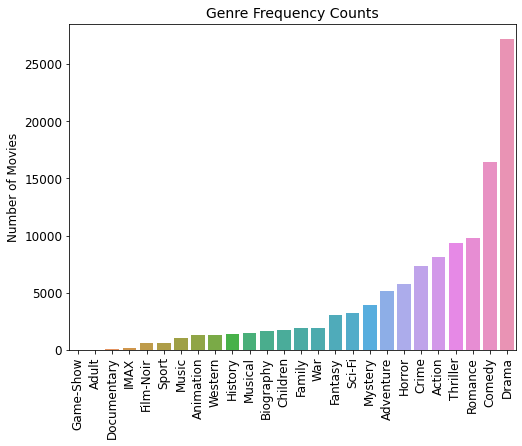

In [23]:
barplot(genre_counts, 'genres', 'cnt', 'Genre Frequency Counts', 'Number of Movies')

__Most Common Genre Combinations__

In [24]:
# convert list to tuple so hashable
df.genres_all = df.genres_all.apply(tuple)

# count by unique genre combination (verified lists internally sorted the same)
genre_combos = df.groupby('genres_all').movieId.count().to_frame()
genre_combos.columns = ['cnt']

# take top 10 most popular
genre_combos = genre_combos.sort_values('cnt').tail(10)

# clean index string 
genre_combos.index = genre_combos.index.map(str)
genre_combos['lst'] = genre_combos.index
genre_combos.lst = genre_combos.lst.str.replace('(', '').str.replace(')', '').str.replace(',', '')

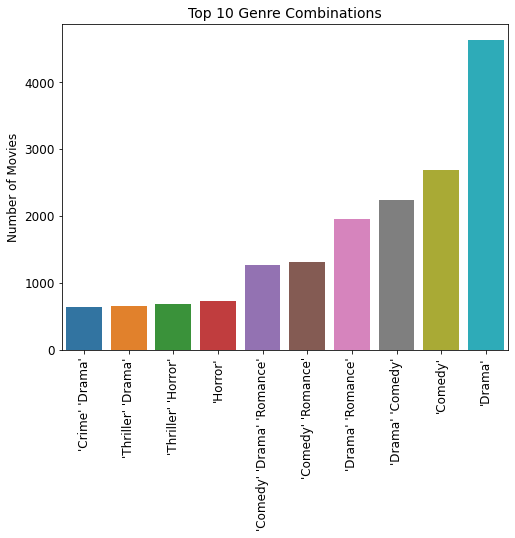

In [25]:
barplot(genre_combos, 'lst', 'cnt', 'Top 10 Genre Combinations', 'Number of Movies')

__Frequency of Movies by Year__

In [26]:
movies_yr = df.groupby('year').movieId.count().to_frame()

Text(0.5, 1.0, 'Release Year Frequency Counts')

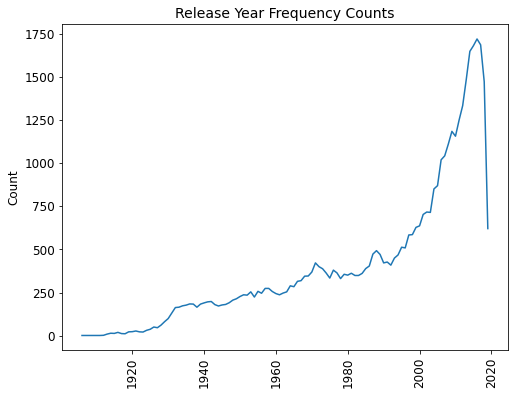

In [27]:
fig, ax = plt.subplots(figsize = (8,6))
sns.lineplot(movies_yr.index, movies_yr.movieId)
plt.xticks(rotation='vertical', size = 12)
plt.yticks(size = 12)

ax.set_xlabel('')
ax.set_ylabel('Count', size = 12)
ax.set_title('Release Year Frequency Counts', size = 14)

__Number of Movies by Filming Country__

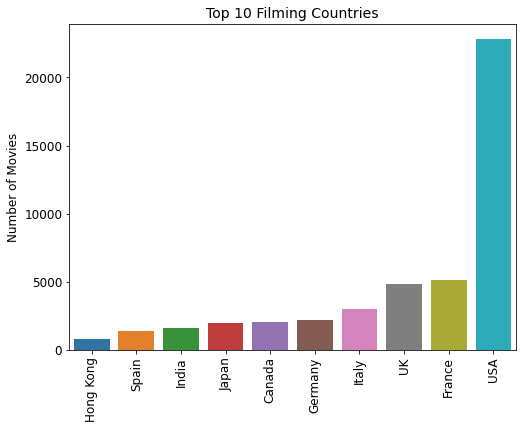

In [28]:
barplot(country_counts.tail(10), 'country', 'cnt', 'Top 10 Filming Countries', 'Number of Movies')

__Most Common Actors__

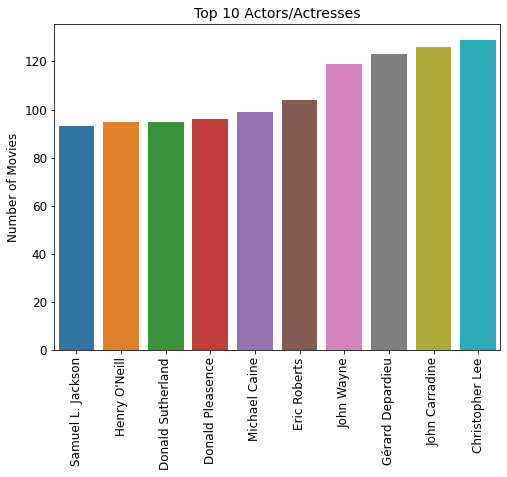

In [29]:
barplot(actors_counts.tail(10), 'actors', 'cnt', 'Top 10 Actors/Actresses', 'Number of Movies')

__Most Common Directors__

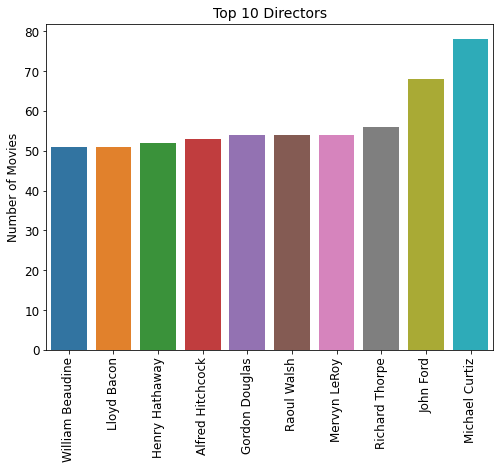

In [30]:
barplot(directors_counts.tail(10), 'director', 'cnt', 'Top 10 Directors', 'Number of Movies')

### Genome Tags

__Distribution of Tag Relevance__    
Most tags have low relevance for most movies

Text(0.5, 1.0, 'Distribution of Tag Relevance Scores')

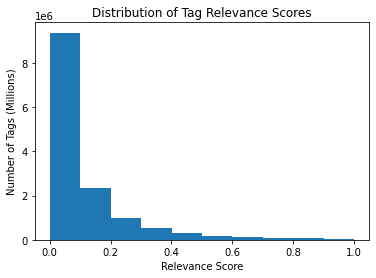

In [31]:
plt.hist(tags.relevance)
plt.xlabel('Relevance Score')
plt.ylabel('Number of Tags (Millions)')
plt.title('Distribution of Tag Relevance Scores')

__Most Common Genome Tags__

In [32]:
# limit to tags that have over 50% relevance for a movie
relevant_tags = tags[tags.relevance > 0.5]

In [33]:
tag_count = relevant_tags.groupby('tag').movieId.count().to_frame()
tag_count.columns = ['cnt']
tag_count['tag'] = tag_count.index
tag_count = tag_count.sort_values('cnt')

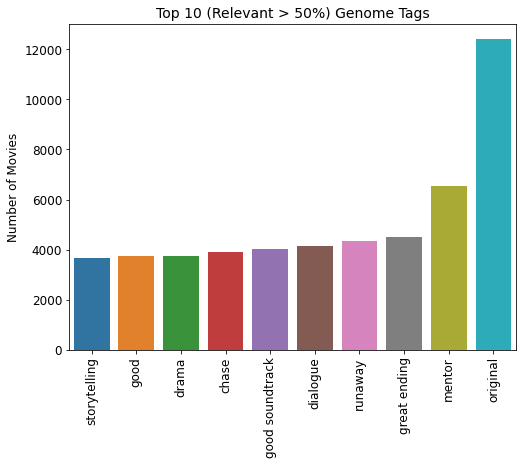

In [34]:
barplot(tag_count.tail(10), 'tag', 'cnt', 'Top 10 (Relevant > 50%) Genome Tags', 'Number of Movies')

__Number of Tags per Movie__    
When we filter, how much can we expect to return for each tag

In [35]:
tag_movies = relevant_tags.groupby('movieId').tag.count().to_frame()
tag_movies.columns = ['cnt']
tag_movies['movie'] = tag_movies.index
tag_movies = tag_movies.sort_values('cnt')

Text(0.5, 1.0, 'Distribution of Number of Tags per Movie')

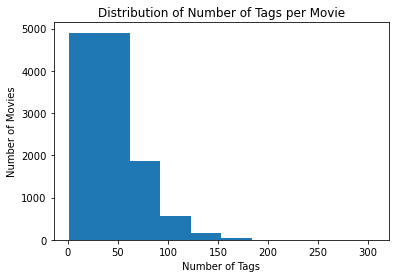

In [36]:
plt.hist(tag_movies.cnt)
plt.xlabel('Number of Tags')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number of Tags per Movie')

## Ratings Data

__Frequency of Year of Review__: Do we have older reviews that should be downweighted?

In [37]:
# convert timestamp to date variable
ratings['date'] =  ratings.timestamp.apply(lambda row: datetime.datetime.fromtimestamp(row))
ratings['year'] = ratings.date.dt.year

# count number of ratings per year
ratings_year = ratings.groupby('year').rating.count().to_frame()
ratings_year.columns = ['cnt']
ratings_year['year'] = ratings_year.index

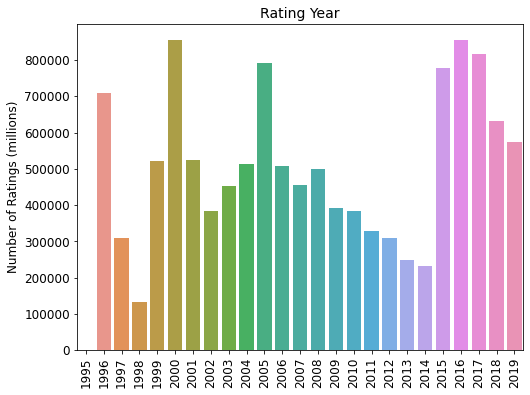

In [38]:
barplot(ratings_year, 'year', 'cnt', 'Rating Year', 'Number of Ratings (millions)')

__Distribution of Number of Ratings by Movie__: How much of a long tail do we have of less popular movies?    
Lots of movies with only a few ratings (<10)

Text(0.5, 1.0, 'Distribution of Number Ratings by Movie: Many "Unpopular" Movies')

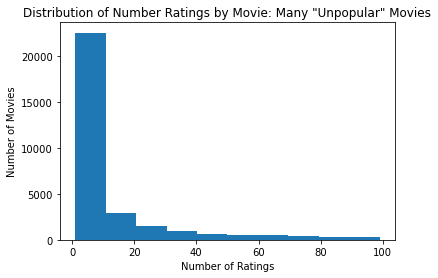

In [39]:
ratings_movie = ratings.groupby('movieId').rating.count().to_frame()
plt.hist(ratings_movie[ratings_movie.rating < 100].rating)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number Ratings by Movie: Many "Unpopular" Movies') 

In [40]:
# How many movies with zero ratings?
len(df[~df.movieId.isin(ratings.movieId.unique())])

6822

In [41]:
# percent of movies with fewer than 10 ratings (if have at least 1 rating)
len(ratings_movie[ratings_movie.rating < 10]) / len(ratings_movie)

0.5754235291037155

__Distribution of Ratings__: more positive or more negative ratings?    
Skewed towards positive ratings -- good for our purposes, don't care much about low ratings

Text(0.5, 1.0, 'Distribution of Ratings')

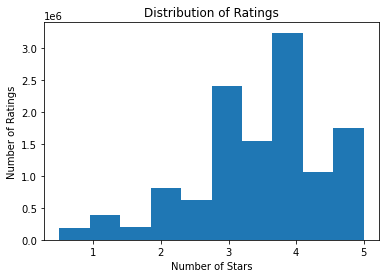

In [42]:
plt.hist(ratings.rating)
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Ratings')

## Most Highly Rated 

In [24]:
def most_highly_rated(var):
    
    ratings_gb = df_full.groupby(var).rating.mean().to_frame()
    ratings_gb.columns = ['avg']
    ratings_gb['id'] = ratings_gb.index
    ratings_gb = pd.merge(ratings_gb, df[['movieId', 'title_eng']], left_on = 'id', right_on = 'movieId')

    # many movies with average = 5, but many of these have only been rated a few times
    # merge and secondary sort by number of ratings
    num_ratings = df_full.groupby('movieId').rating.count().to_frame()
    num_ratings.columns = ['cnt']
    num_ratings['id'] = num_ratings.index

    ratings_gb = pd.merge(ratings_gb, num_ratings, on = 'id')

    # sort on rating and number of ratings
    ratings_gb = ratings_gb.sort_values(['avg',  'cnt'], ascending = True)
    
    return ratings_gb

__Most highly rated movies: Average with at least 100 ratings__

In [25]:
movie_ratings = most_highly_rated('movieId')

_Save df for non-user recommendations: number of ratings and average ratings_

In [27]:
movie_ratings.to_parquet('movies_ratings.parq', engine = 'fastparquet', compression = 'GZIP')

(0.0, 5.0)

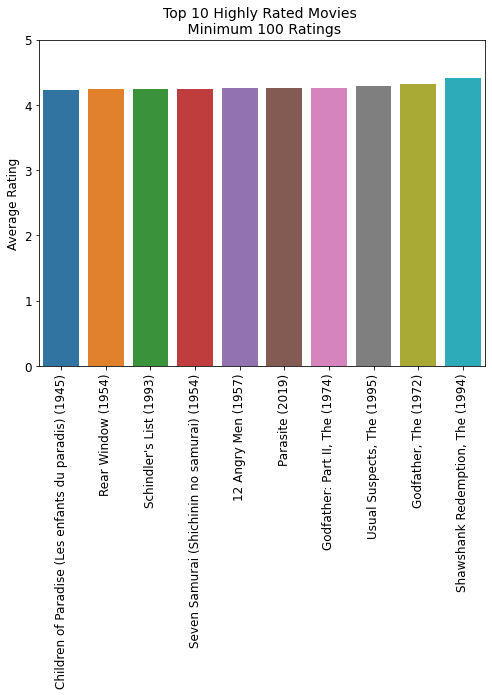

In [46]:
# exclude if fewer than 100 ratings
movie_ratings_100 = movie_ratings[movie_ratings.cnt >= 100]

# plot
ax = barplot(movie_ratings_100.tail(10), 'title_eng', 'avg',
             'Top 10 Highly Rated Movies \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated movies: Weighted Average__

In [33]:
movie_ratings['weighted_avg'] = movie_ratings.avg * movie_ratings.cnt
movie_ratings = movie_ratings.sort_values('weighted_avg')

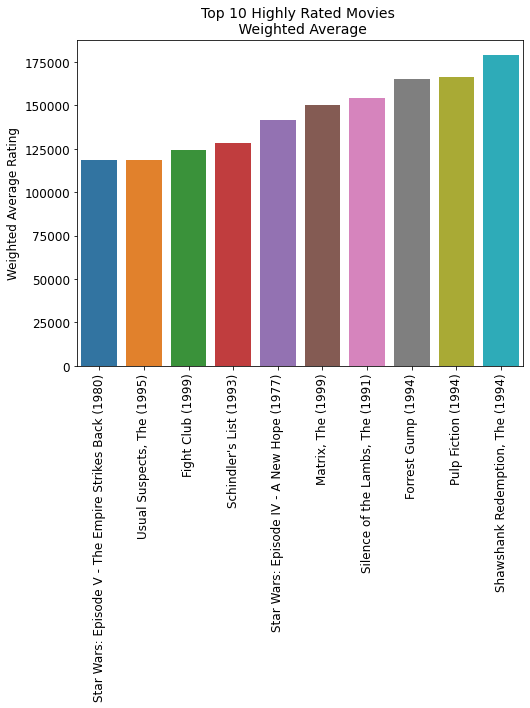

In [34]:
# plot
ax = barplot(movie_ratings.tail(10), 'title_eng', 'weighted_avg', 'Top 10 Highly Rated Movies \n Weighted Average', 
             'Weighted Average Rating')

__Most highly rated actors__    
Average scores of all movies they are in 

In [47]:
# expand
actors_expanded = cat_list_expand(df, 'actors_lst')

# merge with movie rating data: get average rating and rating count of each movie each actor has been in
# excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
actors_rating = pd.merge(actors_expanded, movie_ratings, on = 'movieId')
# aggregate by actor
actors_rating = actors_rating.groupby('actors_lst').agg({'avg':'mean', 'cnt':'sum'})
actors_rating['actor'] = actors_rating.index
actors_rating = actors_rating.sort_values('avg')

# exclude if in total movies with less than 100 ratings
actors_rating = actors_rating[actors_rating.cnt >= 100]

(0.0, 5.0)

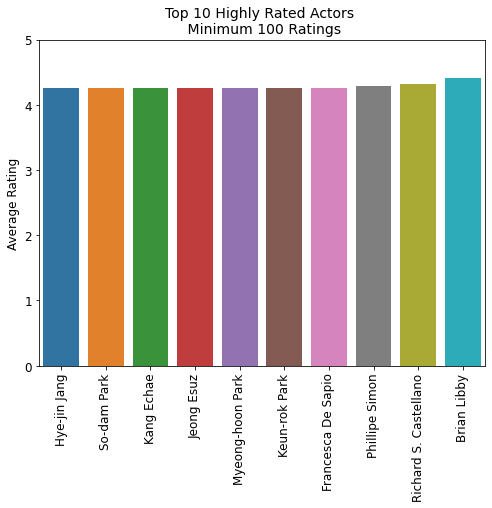

In [48]:
ax = barplot(actors_rating.tail(10), 'actor', 'avg', 'Top 10 Highly Rated Actors \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated directors__

In [49]:
# expand
directors_expanded = cat_list_expand(df, 'director_lst')

# merge with movie rating data: get average rating and rating count of each movie each actor has been in
# excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
director_rating = pd.merge(directors_expanded, movie_ratings, on = 'movieId')
# aggregate by actor
director_rating = director_rating.groupby('director_lst').agg({'avg':'mean', 'cnt':'sum'})
director_rating['director'] = director_rating.index
director_rating = director_rating.sort_values('avg')

# exclude if in total movies with less than 100 ratings
director_rating = director_rating[director_rating.cnt >= 100]

(0.0, 5.0)

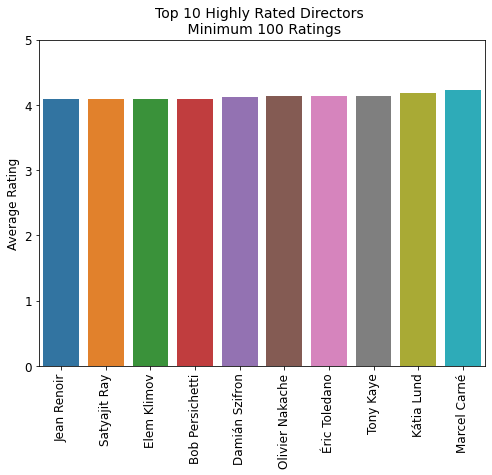

In [50]:
ax = barplot(director_rating.tail(10), 'director', 'avg',
             'Top 10 Highly Rated Directors \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated genres__

In [51]:
# expand
genres_expanded = cat_list_expand(df, 'genres_all')

# merge with movie rating data: get average rating and rating count of each movie each actor has been in
# excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
genres_expanded = pd.merge(genres_expanded, movie_ratings, on = 'movieId')
# aggregate by genre
genres_expanded = genres_expanded.groupby('genres_all').agg({'avg':'mean', 'cnt':'sum'})
genres_expanded['genre'] = genres_expanded.index
genres_expanded = genres_expanded.sort_values('avg')

# exclude if in total movies with less than 100 ratings
#genres_expanded = genres_expanded[genres_expanded.cnt >= 100]

(0.0, 5.0)

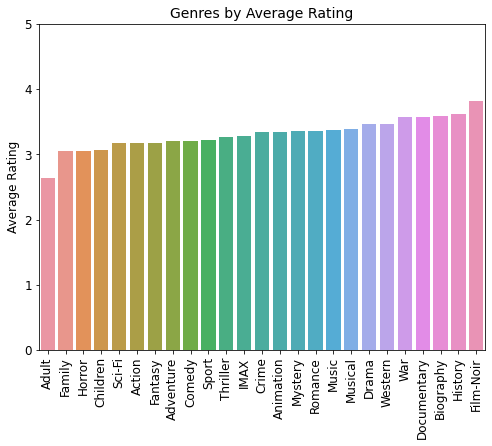

In [52]:
ax = barplot(genres_expanded, 'genre', 'avg',
             'Genres by Average Rating', 'Average Rating')
ax.set_ylim(0,5)

## Create Dummy Variables  
- Exclude actors, directors, countries that are only in 1 movie: not useful for recommendations
- Get top 3 actors from each movies. "Top" defined by how many movies they have appeared in 
- Check again for actors only in 1 movie after top3 exclusion 
- Create dummy variables for actors, directors, countries   
   
Keep movies that do not have any actors, directors, countries based on the above exclusions. Can still be recommended based on other attributes

__Exclude Rare Actors, Directors, Countries: Not Useful for Recommendations__    
And including all results in memory errors

In [53]:
# exclude if only in 1 movie (in dataset)
df.actors_lst = df.actors_lst.map(set) - set(actors_exclude)
df.director_lst = df.director_lst.map(set) - set(directors_exclude)
df.country_lst = df.country_lst.map(set) - set(country_exclude)

# map back to list
df.actors_lst = df.actors_lst.map(list)
df.director_lst = df.director_lst.map(list)
df.country_lst = df.country_lst.map(list)

__Get Top 3 actors from each movie based on appearances in all movies__            
If small movie where actors only appeared a few times, will still get those actors.   
For big movies, drop the background characters and focus on the big names    
    
3 hours to run

In [54]:
def get_top_actors(row, i):
    if len(row) >= i:
        return row[-i][0]
    else:
        return ''

In [55]:
# merge in number of movies each actor has been in based on actors_counts dataframe

#actors_explode = cat_list_expand(df, 'actors_lst')

#actors_movie_counts = actors_explode.actors_lst.apply(lambda row: actors_counts[actors_counts.actors == row].cnt.values[0]
#                                            ).to_frame()
#actors_movie_counts.columns = ['movie_cnt']
#actors_explode = pd.merge(actors_explode, actors_movie_counts, left_index = True, right_index = True)

In [56]:
# for each movie, sort by the number of appearances of each actor and keep the top 3 actors  
#actors_explode = actors_explode.sort_values(['movieId', 'movie_cnt'], ascending = False)
#actors_explode['actor_rank'] = 1
#actors_explode['actor_rank'] = actors_explode.groupby('movieId').actor_rank.cumsum()
#actors_explode = actors_explode[actors_explode.actor_rank <= 3]

# get list of unique actors for each movie 
#actors_explode = actors_explode.groupby('movieId').actors_lst.unique()

In [57]:
# convert to dataframe so compatible with parquet save
#actors_explode = actors_explode.to_frame()
#actors_explode.columns = ['actors_top3']
#actors_explode = actors_explode.actors_top3.map(list).to_frame()

In [73]:
#actors_explode.to_parquet('top3_actors.parq', engine = 'fastparquet', compression = 'GZIP')
actors_explode = pd.read_parquet('top3_actors.parq')

In [74]:
# merge top3 actors list with main movie dataframe
# OUTER merge so keep movies without any relevant actors 
actors_explode = actors_explode.actors_top3.map(list).to_frame()
df = pd.merge(df, actors_explode, left_on = 'movieId', right_index = True, how = 'outer')

In [75]:
# when missing after merge, replace to empty list rather than null
df.actors_top3 = df.actors_top3.apply(lambda d: d if isinstance(d, list) else [])

__Check again for actors in 1 movie__   
Now that have excluded some actors, once again look if any are in only 1 movie and thus not helpful for comparisons

In [61]:
# expand actor list
actors_expanded = cat_list_expand(df, 'actors_top3')

# count number of movies for each actor and prep for plotting 
actors_expanded = actors_expanded.groupby('actors_top3').actors_top3.count().to_frame()
actors_expanded.columns = ['cnt']
actors_expanded = actors_expanded.sort_values(['cnt'])
actors_expanded['actors'] = actors_expanded.index
actors_exclude_top3 = actors_expanded[actors_expanded.cnt == 1].actors.unique()

In [62]:
# exclude if only in 1 movie (in this processed dataset)
df.actors_top3 = df.actors_top3.map(set) - set(actors_exclude_top3)

# map back to list
df.actors_top3 = df.actors_top3.map(list)

__Create Dummies__    

In [63]:
# clear up memory 
del imdb_movies
del actors_expanded
del directors_expanded 
del movies
del links

In [64]:
x = len(df)

In [65]:
for var in ['genres_all', 'actors_top3', 'director_lst']:

    prefix = var.split('_')[0]

    # dummy variables
    dummies = pd.get_dummies(df[var].apply(pd.Series).stack(), prefix = prefix).sum(level = 0)

    # merge back in
    # OUTER merge so that keep if don't have any entries in the dummies (empty list)
    df = pd.merge(df, dummies, left_index = True, right_index = True, how = 'outer')

In [66]:
assert len(df) == x

In [72]:
len(df)

45013

In [67]:
# replace NaN to 0 
dum_cols = [i for i in df.columns if i.startswith('genres_') | i.startswith('actors_') | i.startswith('director_')]
for i in dum_cols:
    df[i] = np.where(df[i].isnull(), 0, df[i])

### Drop Variables + Save

In [68]:
df = df.drop(columns = ['genre', 'genres', 'director', 'actors', 'country', 'genres_all', 'director_lst', 'actors_lst', 
                       'country_lst', 'actors_top3'])
df.to_pickle('processed_df.pkl')

## Create User-Ratings Utility Matrix

In [ ]:
ratings = ratings.sort_values(['userId', 'movieId'])
users_c = CategoricalDtype(sorted(ratings.userId.unique()), ordered=True)
movies_c = CategoricalDtype(sorted(ratings.movieId.unique()), ordered=True)

row = ratings.userId.astype(users_c).cat.codes
col = ratings.movieId.astype(movies_c).cat.codes
utility_matrix = csc_matrix((ratings.rating, (row, col)), 
                           shape=(users_c.categories.size, movies_c.categories.size))

utility_matrix.shape # row = users, columns = movies

In [ ]:
# check: look at userId = 1, what movies have non-zero values in the matrix?
print(utility_matrix[0,:].nonzero())

# find indexes of movie IDs 
movies_lst = sorted(ratings.movieId.unique())
movies_lst.index(296) # movieId 296 = index 292. First nonzero element in sparse matrix. 

In [ ]:
ratings[ratings.userId == 1]